# Natural Language Processing

A Naive Bayes model to detect spam messages vs. ham (non-spam) messages using the SMS Spam Collection dataset downloaded from the UCI ML Repository. See more information about the dataset at these sites:

* http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/
* http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
import nltk

In [3]:
messages = pd.read_csv('SMS Spam Collection/SMSSpamCollection',sep='\t',names=['Label','Message'])

In [4]:
messages.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
messages['Length'] = messages['Message'].apply(len)

In [6]:
messages.head()

,Label,Message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [50]:
messages.describe(include=[np.object])

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [51]:
messages.describe()

,Length
count,5572.000000
mean,80.489950
std,59.942907
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


In [8]:
messages.groupby('Label').describe()

Length                                                         
        count        mean        std   min    25%    50%    75%    max
Label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

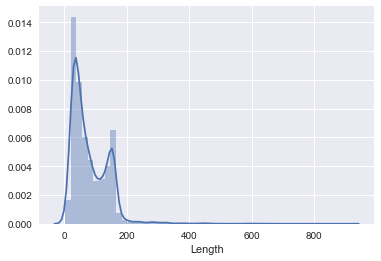

In [9]:
sns.distplot(messages['Length'])

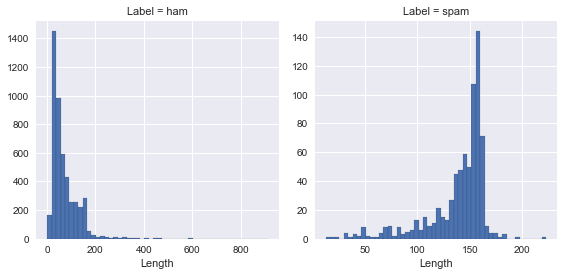

In [10]:
histbylabel = sns.FacetGrid(messages, col='Label', margin_titles=True, size=4, sharex=False, sharey=False)
histbylabel.map(plt.hist, 'Length', edgecolor='black', lw=0.1, bins=50);

Note that the x and y axes for the two plots above are not the same.

Ham messages tend to be shorter than spam messages.

## Clean text

Remove punctuation and stopwords from messages then tokenize them.

In [11]:
import string
from nltk.corpus import stopwords

In [12]:
def strippunc(message):
    nopunc = [c for c in message if c not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split()]

In [13]:
def stripstopwords(message):
    nostripwords = [word for word in message.split() if word.lower() not in stopwords.words('english')]
    return ' '.join(nostripwords).split(" ")

In [14]:
def stripuseless(message):
    noextras = [character for character in message if character not in string.punctuation]
    noextras = ''.join(noextras)
    return [word for word in noextras.split() if word.lower() not in stopwords.words('english')]

In [15]:
messages['Message'].head().apply(strippunc)

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, dont, think, he, goes, to, usf, he, l...
Name: Message, dtype: object

In [16]:
messages['Message'].head().apply(stripstopwords)

0    [Go, jurong, point,, crazy.., Available, bugis...
1                 [Ok, lar..., Joking, wif, u, oni...]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3    [U, dun, say, early, hor..., U, c, already, sa...
4      [Nah, think, goes, usf,, lives, around, though]
Name: Message, dtype: object

In [17]:
messages['Message'].head().apply(stripuseless)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: Message, dtype: object

## Splitting training and test data

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
training_messages, test_messages, train_labels, test_labels = train_test_split(messages['Message'], messages['Label'], test_size = 0.33, random_state=47)

## Vectorize messages and create term-document matrix

Create bag-of-words model and term-document matrix.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
bagofwords_transformer = CountVectorizer(analyzer=stripuseless)
bagofwords_transformer.fit(training_messages)

CountVectorizer(analyzer=<function stripuseless at 0x00000243BAA1AD08>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [22]:
print(len(bagofwords_transformer.vocabulary_))

9098


In [28]:
training_termdocmatrix = bagofwords_transformer.transform(training_messages)

In [29]:
training_termdocmatrix.shape

(3733, 9098)

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer

In [30]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(training_termdocmatrix)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [31]:
training_tfidfmatrix = tfidf_transformer.transform(training_termdocmatrix)

In [32]:
test_termdocmatrix = bagofwords_transformer.transform(test_messages)
test_tfidfmatrix = tfidf_transformer.transform(test_termdocmatrix)

## Naive Bayes spam detection model

In [33]:
from sklearn.naive_bayes import MultinomialNB

In [35]:
spam_detection_model = MultinomialNB().fit(training_tfidfmatrix, train_labels)

In [36]:
spam_detection_model.predict(training_tfidfmatrix)[3]

'ham'

In [37]:
train_labels[3]

'ham'

In [46]:
spam_detection_model.score(training_tfidfmatrix, train_labels)

0.97589070452718996

In [44]:
spam_detection_model.predict(test_tfidfmatrix)[3]

'ham'

In [43]:
test_labels.iloc[3]

'ham'

In [45]:
spam_detection_model.score(test_tfidfmatrix, test_labels)

0.95649809679173459

## Model evaluation

In [52]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [48]:
print(classification_report(test_labels, spam_detection_model.predict(test_tfidfmatrix)))

             precision    recall  f1-score   support

        ham       0.95      1.00      0.98      1591
       spam       1.00      0.68      0.81       248

avg / total       0.96      0.96      0.95      1839



95% of messages predicted as ham were actually ham.
100% of actual ham messages were predicted as ham.

100% of messages predicted as spam were actually spam.
68% of actual spam messages were predicted as spam.

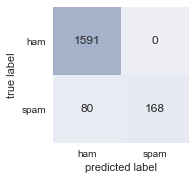

In [64]:
with sns.axes_style({'axes.grid':False}):
    cm_fig, cm_ax = plot_confusion_matrix(confusion_matrix(test_labels, spam_detection_model.predict(test_tfidfmatrix)))
    cm_ax.set_xticklabels(['','ham','spam'])
    cm_ax.set_yticklabels(['','ham','spam'])